In [2]:
import pandas as pd
import numpy as np

In [4]:
df_train = pd.read_csv('train_wlabels.csv')
df_test = pd.read_csv('test_wlabels.csv')

x_train = df_train.drop('label', axis=1).values
y_train = df_train['label'].values

x_test = df_test.drop('label', axis=1).values
y_test = df_test['label'].values

print(f"Kích thước của train và labels {x_train.shape} {y_train.shape}")
print(f"Kích thước của test và labels {x_test.shape} {y_test.shape}")

Kích thước của train và labels (5668, 16) (5668,)
Kích thước của test và labels (2834, 16) (2834,)


## RandomForest classifier

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# phân loại bằng RandomForest
accuracy = []
y_pred = []
for i in range(1):
    rf_model = RandomForestClassifier(
        n_estimators=300, max_depth=20, 
        min_samples_split=2,min_samples_leaf=1,
        max_features='sqrt',bootstrap=True
        )
    rf_model.fit(x_train, y_train)
    y_pred = rf_model.predict(x_test)
    
    accuracy.append(accuracy_score(y_test, y_pred))
    print(f'Accuracy: {accuracy[i] * 100:.2f}%')

print(f'Average Accuracy: {np.mean(accuracy) * 100:.2f}%')

Accuracy: 98.20%
Average Accuracy: 98.20%


## Confusion Matrix

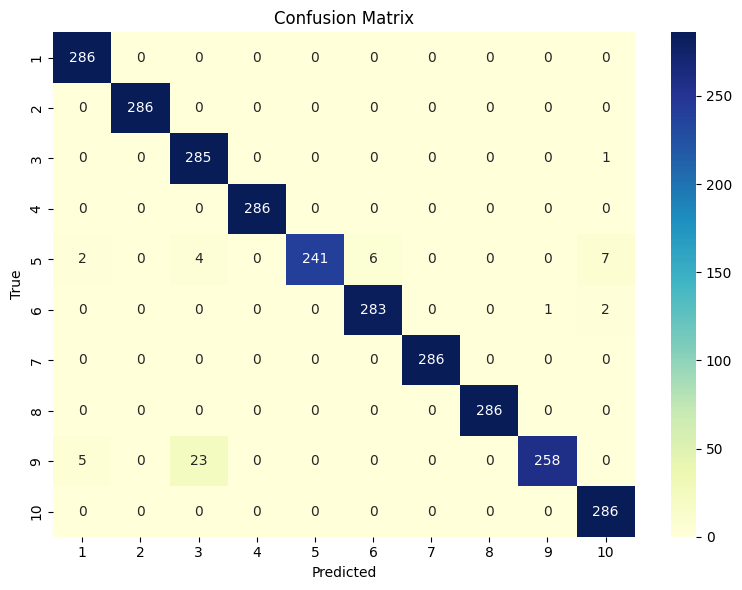

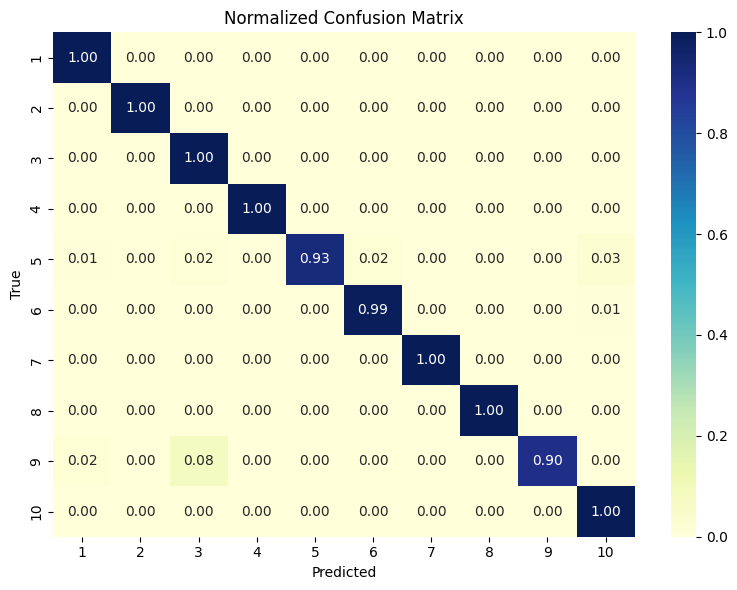

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_names = [1,2,3,4,5,6,7,8,9,10]

def draw_confusion_matrix(y_test = y_test, y_pred = y_pred, class_names = class_names):
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # --- Vẽ confusion matrix gốc ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='YlGnBu',
        xticklabels=class_names, yticklabels=class_names
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # --- Vẽ confusion matrix đã chuẩn hóa ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_normalized, annot=True, fmt='.2f', cmap='YlGnBu',
        xticklabels=class_names, yticklabels=class_names
    )
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
draw_confusion_matrix(y_test, y_pred, class_names) # OKE

C:\Users\HUY\AppData\Local\Temp\ipykernel_10396\848655112.py:26: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)


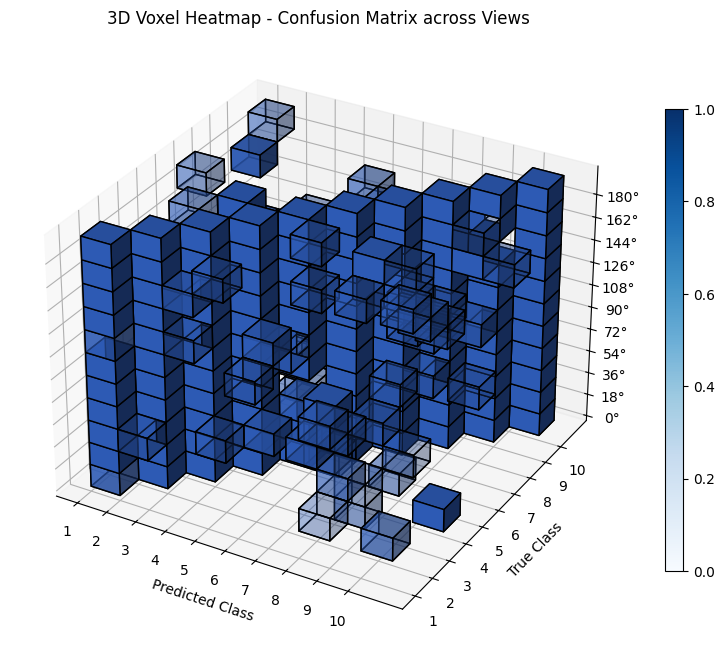

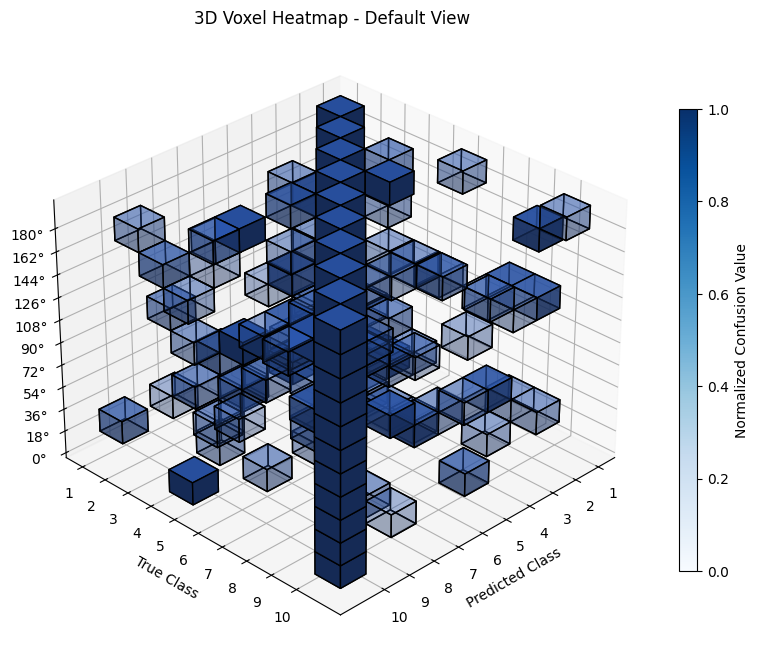

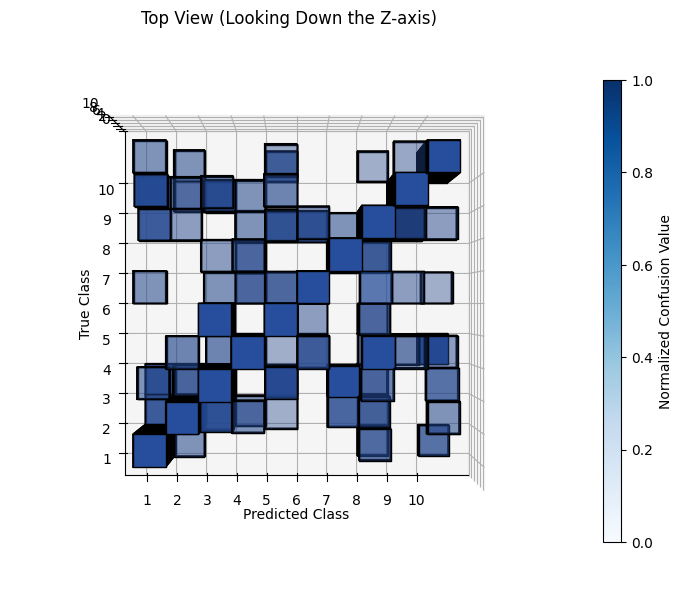

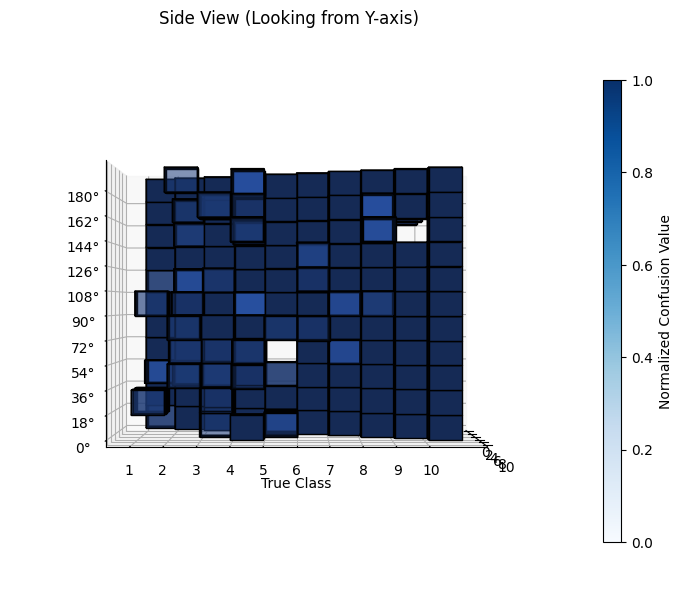

In [7]:
import matplotlib as mpl

def heatmap_3d():
    # Tạo dữ liệu giả
    class_names = list(range(1, 11))  # 10 đối tượng
    views = [0, 18, 36, 54, 72,90, 108, 126, 144, 162, 180] # 11 hướng đi

    y_test_all, y_pred_all = [], []

    for view in views:
        y_true = np.random.choice(class_names, 50)
        y_pred = [y if np.random.rand() > 0.2 else np.random.choice(class_names) for y in y_true]
        y_test_all.append(y_true)
        y_pred_all.append(y_pred)

    # Kích thước của voxel grid
    n_class, n_view = len(class_names), len(views)

    # Tạo lưới voxel: shape (true, pred, view)
    voxel_data = np.zeros((n_class, n_class, n_view))
    colors = np.empty(voxel_data.shape + (4,), dtype=np.float32)  # RGBA

    # Lấp dữ liệu confusion matrix vào voxel
    for v_idx, view in enumerate(views):
        cm = confusion_matrix(y_test_all[v_idx], y_pred_all[v_idx], labels=class_names)
        cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

        for i in range(n_class):        # true class
            for j in range(n_class):    # predicted class
                value = cm_norm[i, j]
                voxel_data[i, j, v_idx] = value > 0.05  # chỉ hiện khối nếu đủ lớn
                alpha = min(value * 2, 1.0)
                colors[i, j, v_idx] = [0.2, 0.4, 0.8, alpha]  # xanh lam với độ trong suốt

    # Vẽ voxel heatmapheatmap
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.voxels(voxel_data, facecolors=colors, edgecolor='k')

    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')

    ax.set_xticks(np.arange(n_class))
    ax.set_xticklabels(class_names)
    ax.set_yticks(np.arange(n_class))
    ax.set_yticklabels(class_names)
    ax.set_zticks(np.arange(n_view))
    ax.set_zticklabels([f'{v}°' for v in views])
    ax.set_title('3D Voxel Heatmap - Confusion Matrix across Views')

    # Tạo colorbar và sử dụng color bar cho độ trong suốt (alpha value)
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])  # Cần thiết để colorbar hoạt động
    fig.colorbar(sm, ax=ax, shrink=0.75, aspect=25)

    plt.show()
    
    # Đồ thị góc chính diện
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(voxel_data, facecolors=colors, edgecolor='k')

    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    ax.set_xticks(np.arange(n_class))
    ax.set_xticklabels(class_names)
    ax.set_yticks(np.arange(n_class))
    ax.set_yticklabels(class_names)
    ax.set_zticks(np.arange(n_view))
    ax.set_zticklabels([f'{v}°' for v in views])
    ax.set_title('3D Voxel Heatmap - Default View')
    ax.view_init(elev=30, azim=45)

    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, shrink=0.75, aspect=25, label='Normalized Confusion Value')

    plt.show()

    # Đồ thị nhìn từ trên cao xuống
    fig = plt.figure(figsize=(9, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(voxel_data, facecolors=colors, edgecolor='k')

    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    ax.set_xticks(np.arange(n_class))
    ax.set_xticklabels(class_names)
    ax.set_yticks(np.arange(n_class))
    ax.set_yticklabels(class_names)
    ax.set_title('Top View (Looking Down the Z-axis)')
    ax.view_init(elev=90, azim=-90)

    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, shrink=0.75, aspect=25, label='Normalized Confusion Value')

    plt.show()

    # Đồ thị nhìn từ bên hông qua
    fig = plt.figure(figsize=(9, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(voxel_data, facecolors=colors, edgecolor='k')

    ax.set_ylabel('True Class')
    ax.set_yticks(np.arange(n_class))
    ax.set_yticklabels(class_names)
    ax.set_zticks(np.arange(n_view))
    ax.set_zticklabels([f'{v}°' for v in views])
    ax.set_title('Side View (Looking from Y-axis)')
    ax.view_init(elev=0, azim=0)

    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, shrink=0.75, aspect=25, label='Normalized Confusion Value')

    plt.show()

heatmap_3d()